In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np


#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')


In [2]:
df = pd.read_excel('Speakers_with_speeches_cleaned1.xlsx')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4795 entries, 0 to 4794
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     4795 non-null   int64  
 1   Session                  4795 non-null   int64  
 2   ISO Code                 4795 non-null   object 
 3   Country                  4795 non-null   object 
 4   Name of Person Speaking  4795 non-null   object 
 5   Post                     4795 non-null   object 
 6   Unnamed: 6               0 non-null      float64
 7   Speech                   4783 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 299.8+ KB


In [3]:
df.head()

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6,Speech
0,2024,79,BRA,Brazil,Lula Da Silva,President,NaN,"Mr President of the General Assembly, Philemon..."
1,2024,79,USA,United States Of America,Joseph R. Biden,President,NaN,"My fellow leaders, today is the fourth time I’..."
2,2024,79,TUR,Turkey,Tayyip Erdogan,President,NaN,"Mr. President, dear heads of states and govern..."
3,2024,79,JOR,Jordan,Abdullah Ii Ibn Al Hussein,King,NaN,"Mr President,\n\nMr Secretary General,\n\nYour..."
4,2024,79,GTM,Guatemala,Cesar Bernardo Arevalo De Leon,President,NaN,"- His Excellency Mr Philemon Yang, President o..."


In [4]:
df.shape

(4795, 8)

In [5]:
df.columns

Index(['Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking',
       'Post', 'Unnamed: 6', 'Speech'],
      dtype='object')

In [6]:
def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return []
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # Standard English stops + custom UN-specific stops
    stop_words = set(stopwords.words('english')) | {'united', 'nations', 'assembly', 'general', 'mr', 'president', 'country', 'state', 'new', 'world'}
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Lemmatize with spaCy
    doc = nlp(' '.join(tokens))
    lemmatized = [token.lemma_ for token in doc if not token.is_stop]
    return lemmatized

# Apply preprocessing
df['Tokens'] = df['Speech'].apply(preprocess_text)
df.head()

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6,Speech,Tokens
0,2024,79,BRA,Brazil,Lula Da Silva,President,NaN,"Mr President of the General Assembly, Philemon...","[philemon, yang, extend, greeting, antónio, gu..."
1,2024,79,USA,United States Of America,Joseph R. Biden,President,NaN,"My fellow leaders, today is the fourth time I’...","[fellow, leader, today, fourth, time, great, h..."
2,2024,79,TUR,Turkey,Tayyip Erdogan,President,NaN,"Mr. President, dear heads of states and govern...","[dear, head, state, government, secretary, dis..."
3,2024,79,JOR,Jordan,Abdullah Ii Ibn Al Hussein,King,NaN,"Mr President,\n\nMr Secretary General,\n\nYour...","[secretary, excellency, past, stand, podium, a..."
4,2024,79,GTM,Guatemala,Cesar Bernardo Arevalo De Leon,President,NaN,"- His Excellency Mr Philemon Yang, President o...","[excellency, philemon, yang, session, excellen..."


In [7]:
all_words = [] # list to store all the words
# loop to get each words into a list
for words in df['Tokens']:
    all_words.extend(words)

word_counts = Counter(all_words) # counting the words
print(word_counts.most_common(5)) # displaying top 5 words


[('international', 48315), ('development', 39543), ('people', 34677), ('security', 31885), ('peace', 29982)]


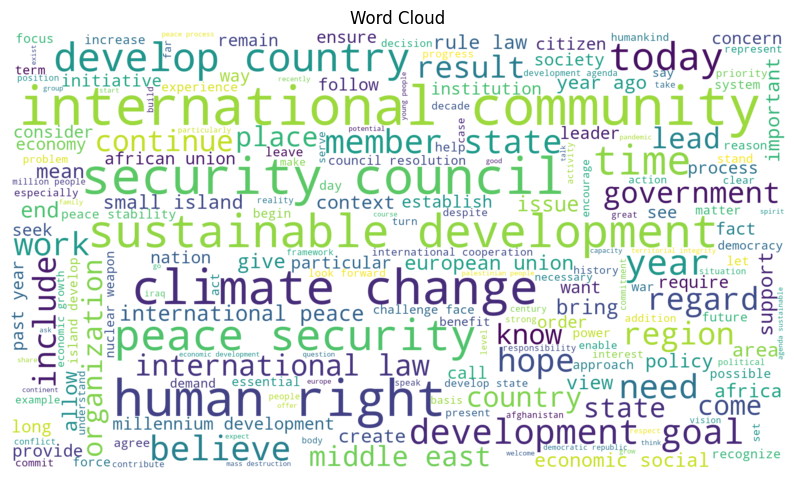

In [8]:
# Combine all words into a single string
text_string = ' '.join(all_words)

# word cloud
wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text_string)

# Displaying the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [9]:
df.shape

(4795, 9)

In [10]:
df['Country'].unique()

array(['Brazil', 'United States Of America', 'Turkey', 'Jordan',
       'Guatemala', 'Switzerland', 'Colombia', 'Qatar', 'South Africa',
       'Maldives', 'Tajikistan', 'Lithuania', 'Sierra Leone', 'Serbia',
       'Angola', 'Mauritania', 'Kyrgyzstan', 'Argentina', 'El Salvador',
       'Iran', 'Estonia', 'Chile', 'Latvia', 'Paraguay', 'Viet Nam',
       'Poland', 'Monaco', 'Nauru', 'Nigeria', 'Bahrain', 'Italy',
       'Morocco', 'Belgium', 'Mongolia', 'Seychelles', 'Czechia',
       'Ukraine', 'Ghana', 'Bulgaria', 'Suriname', 'Cyprus', 'Slovakia',
       'Namibia', 'Lybia', 'Dominican Republic', 'Romania',
       'Democratic Republic Of Congo', 'Guinea-Bissau', 'Cabo Verde',
       'Honduras', 'Liberia', 'Botswana', 'France',
       'Bosnia And Herzegovina', 'Finland', 'Guyana', 'Panama', 'Togo',
       'Senegal', 'Dominica', 'Marshall Islands', 'Georgia', 'Spain',
       'Chad', 'Hungary', 'Uzbekistan', 'Venezuela', 'Zimbabwe',
       'South Sudan', 'Bolivia', 'Malawi', 'Kenya', 'Y

In [11]:
g7_countries = [
    'Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States Of America'
]

g20_countries = [
    'Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia',
    'Italy', 'Japan', 'Mexico', 'Russia', 'Saudi Arabia', 'South Africa', 'Korea, Republic Of', 'Turkey',
    'United Kingdom', 'United States Of America'
]

eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
    'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden'
]

african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde',
    'Central African Republic', 'Chad', 'Comoros', 'Congo, Democratic Republic of the', 'Congo, Republic of the',
    'Cote d\'Ivoire', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
    'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar',
    'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria',
    'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
    'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

In [12]:
def generate_wordcloud_for_group(group_name, country_list):
    # Filter DataFrame for the group
    group_df = df[df['Country'].isin(country_list)]
    if group_df.empty:
        print(f"No data found for {group_name}. Check country names.")
        return
    
    # Combine all tokens from the group's speeches
    all_words = []
    for words in group_df['Tokens']:
        all_words.extend(words)
    
    if not all_words:
        print(f"No words found for {group_name} after preprocessing.")
        return
    
    # Get word frequencies
    word_counts = Counter(all_words)
    print(f"Top 5 words for {group_name}: {word_counts.most_common(5)}")
    
    # Combine into string for word cloud
    text_string = ' '.join(all_words)
    
    # Generate word cloud
    wordcloud = WordCloud(width=1920, height=1080, background_color='white', max_words=200).generate(text_string)
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {group_name} (2000-2024)")
    plt.show()

Top 5 words for G7 Countries: [('international', 1360), ('people', 1180), ('security', 1167), ('japan', 890), ('peace', 845)]


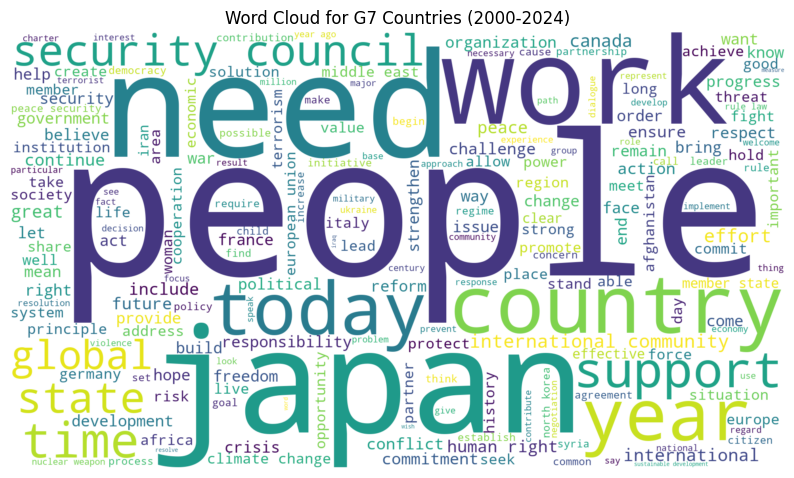

Top 5 words for G20 Countries: [('international', 4149), ('security', 3071), ('people', 2859), ('development', 2828), ('country', 2825)]


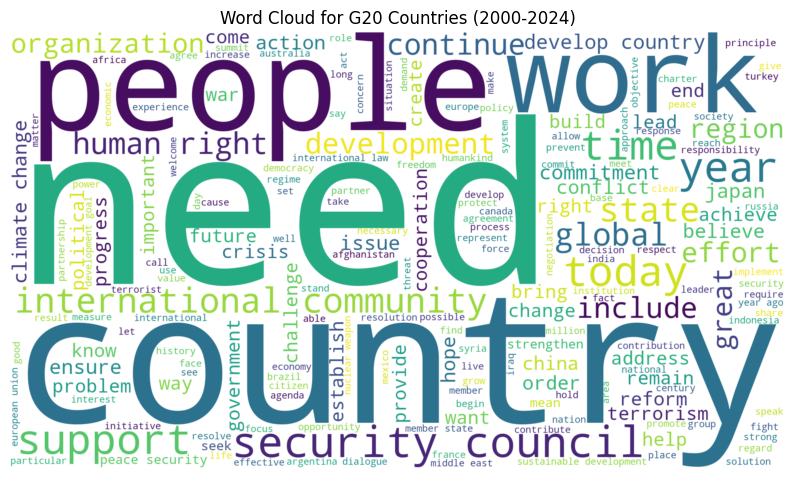

Top 5 words for European Union Countries: [('international', 6382), ('security', 5012), ('development', 4024), ('right', 3913), ('peace', 3633)]


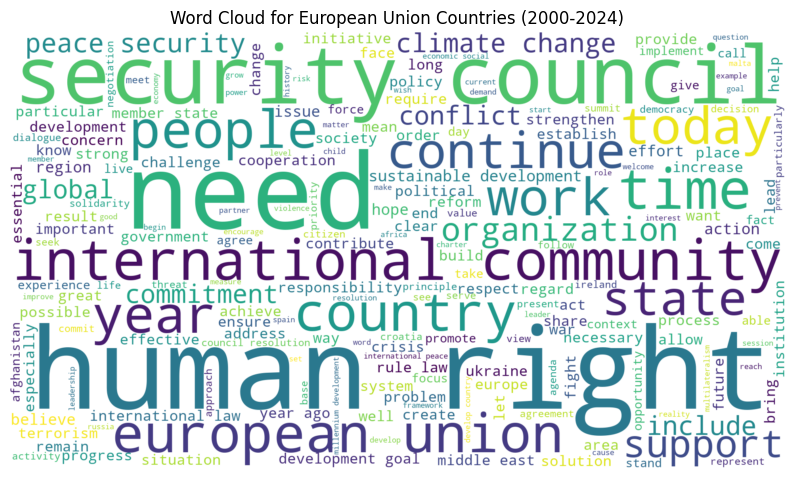

Top 5 words for African Countries: [('international', 10869), ('development', 10325), ('peace', 8195), ('security', 7850), ('people', 7418)]


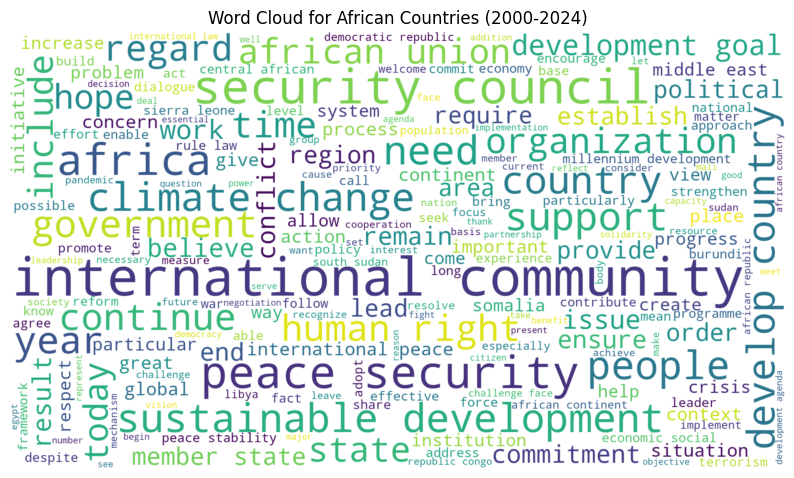

In [13]:
generate_wordcloud_for_group("G7 Countries", g7_countries)
generate_wordcloud_for_group("G20 Countries", g20_countries)
generate_wordcloud_for_group("European Union Countries", eu_countries)
generate_wordcloud_for_group("African Countries", african_countries)

In [14]:
df['Word_Count'] = df['Tokens'].apply(len)
df.head()

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6,Speech,Tokens,Word_Count
0,2024,79,BRA,Brazil,Lula Da Silva,President,NaN,"Mr President of the General Assembly, Philemon...","[philemon, yang, extend, greeting, antónio, gu...",971
1,2024,79,USA,United States Of America,Joseph R. Biden,President,NaN,"My fellow leaders, today is the fourth time I’...","[fellow, leader, today, fourth, time, great, h...",1355
2,2024,79,TUR,Turkey,Tayyip Erdogan,President,NaN,"Mr. President, dear heads of states and govern...","[dear, head, state, government, secretary, dis...",1749
3,2024,79,JOR,Jordan,Abdullah Ii Ibn Al Hussein,King,NaN,"Mr President,\n\nMr Secretary General,\n\nYour...","[secretary, excellency, past, stand, podium, a...",647
4,2024,79,GTM,Guatemala,Cesar Bernardo Arevalo De Leon,President,NaN,"- His Excellency Mr Philemon Yang, President o...","[excellency, philemon, yang, session, excellen...",1000


In [15]:
def get_five_year_period(year):
    if 2000 <= year <= 2004:
        return '2000-2004'
    elif 2005 <= year <= 2009:
        return '2005-2009'
    elif 2010 <= year <= 2014:
        return '2010-2014'
    elif 2015 <= year <= 2019:
        return '2015-2019'
    elif 2020 <= year <= 2024:
        return '2020-2024'
    else:
        return 'Other'

df['Period'] = df['Year'].apply(get_five_year_period)
df.head()

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6,Speech,Tokens,Word_Count,Period
0,2024,79,BRA,Brazil,Lula Da Silva,President,NaN,"Mr President of the General Assembly, Philemon...","[philemon, yang, extend, greeting, antónio, gu...",971,2020-2024
1,2024,79,USA,United States Of America,Joseph R. Biden,President,NaN,"My fellow leaders, today is the fourth time I’...","[fellow, leader, today, fourth, time, great, h...",1355,2020-2024
2,2024,79,TUR,Turkey,Tayyip Erdogan,President,NaN,"Mr. President, dear heads of states and govern...","[dear, head, state, government, secretary, dis...",1749,2020-2024
3,2024,79,JOR,Jordan,Abdullah Ii Ibn Al Hussein,King,NaN,"Mr President,\n\nMr Secretary General,\n\nYour...","[secretary, excellency, past, stand, podium, a...",647,2020-2024
4,2024,79,GTM,Guatemala,Cesar Bernardo Arevalo De Leon,President,NaN,"- His Excellency Mr Philemon Yang, President o...","[excellency, philemon, yang, session, excellen...",1000,2020-2024



Top 10 words in 2000-2004:
[('international', 11864), ('security', 7209), ('development', 7098), ('peace', 6596), ('people', 6279), ('country', 6153), ('state', 4537), ('community', 4531), ('organization', 4184), ('effort', 4103)]


C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\993537983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


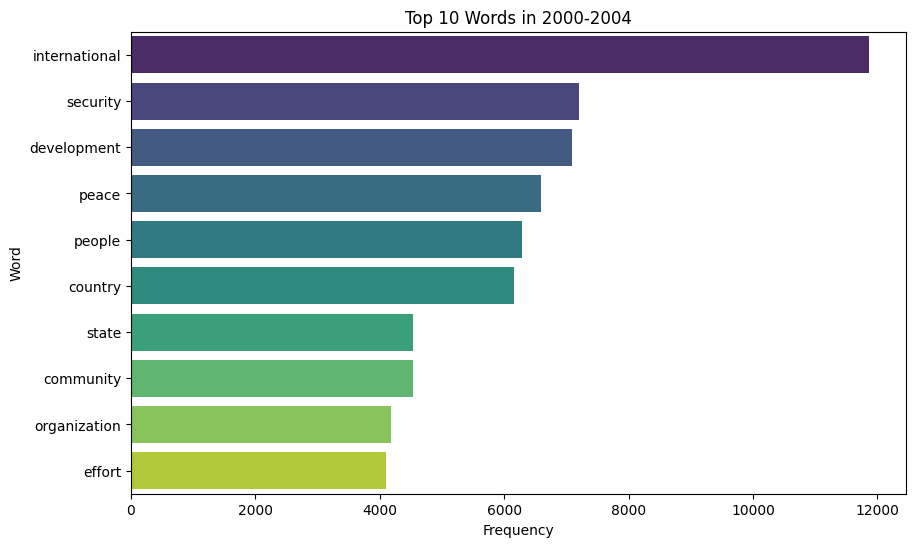


Top 10 words in 2005-2009:
[('international', 9343), ('development', 8046), ('country', 6421), ('security', 6193), ('people', 5576), ('peace', 5290), ('right', 4233), ('support', 4186), ('human', 4068), ('year', 3962)]


C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\993537983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


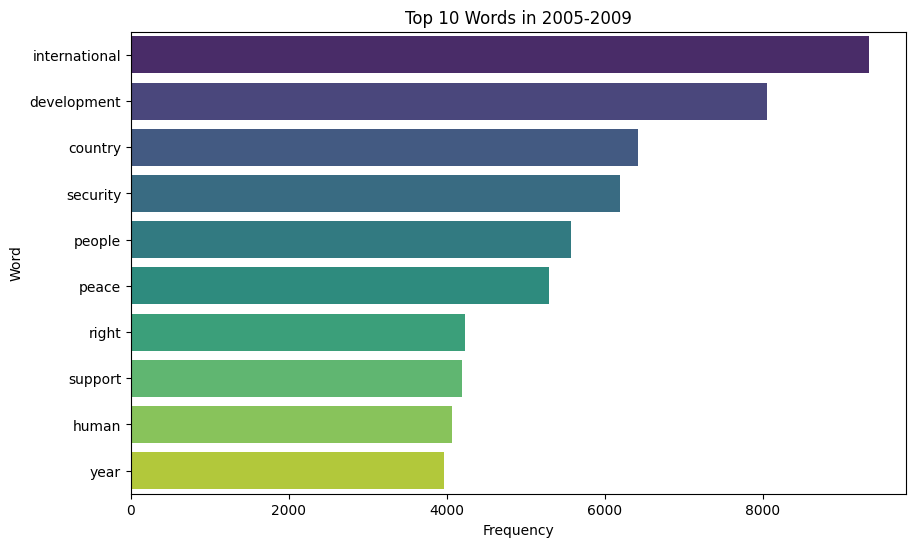


Top 10 words in 2010-2014:
[('international', 10156), ('development', 9252), ('people', 7295), ('security', 6484), ('peace', 5893), ('country', 5613), ('year', 4602), ('support', 4581), ('global', 4489), ('right', 4428)]


C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\993537983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


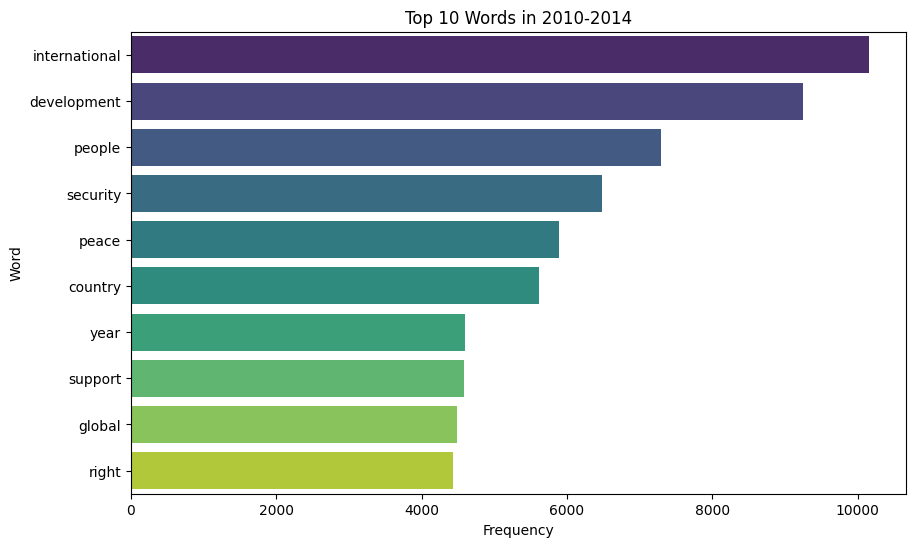


Top 10 words in 2015-2019:
[('development', 8890), ('international', 8522), ('people', 8318), ('peace', 6524), ('security', 6321), ('country', 5303), ('year', 4957), ('right', 4719), ('support', 4626), ('sustainable', 4586)]


C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\993537983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


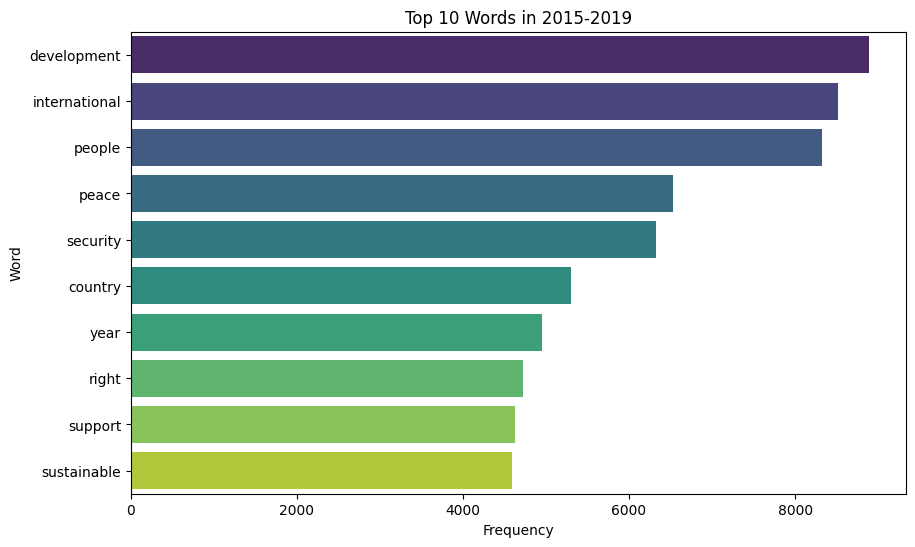


Top 10 words in 2020-2024:
[('international', 8430), ('people', 7209), ('global', 6349), ('development', 6257), ('country', 5732), ('peace', 5679), ('security', 5678), ('support', 4840), ('climate', 4705), ('year', 4426)]


C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\993537983.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


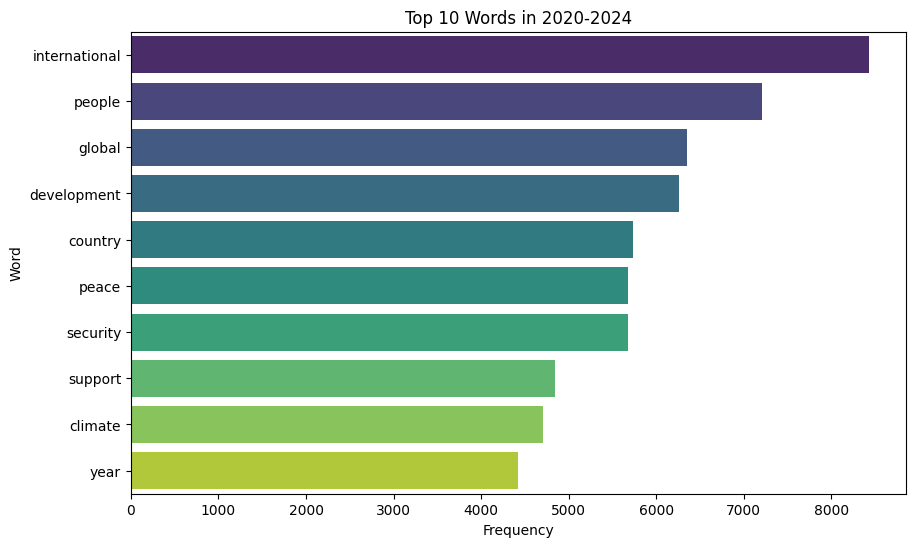

In [16]:
def top_words_by_period(n=10):
    periods = df['Period'].unique()
    for period in sorted(periods):
        period_df = df[df['Period'] == period]
        all_words = []
        for words in period_df['Tokens']:
            all_words.extend(words)
        word_counts = Counter(all_words)
        print(f"\nTop {n} words in {period}:")
        print(word_counts.most_common(n))
        
        top_words = pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Frequency'])
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')
        plt.title(f"Top {n} Words in {period}")
        plt.savefig(f"top_words_{period}.png")
        plt.show()
        
top_words_by_period(n=10)


Stats by Five-Year Period:
      Period  Word_Count                   
                    mean median         std
0  2000-2004  899.462032  863.0  275.190062
1  2005-2009  834.983229  821.0  245.224782
2  2010-2014  908.866183  870.5  296.627765
3  2015-2019  928.296827  889.0  321.724707
4  2020-2024  919.522280  889.0  320.148045


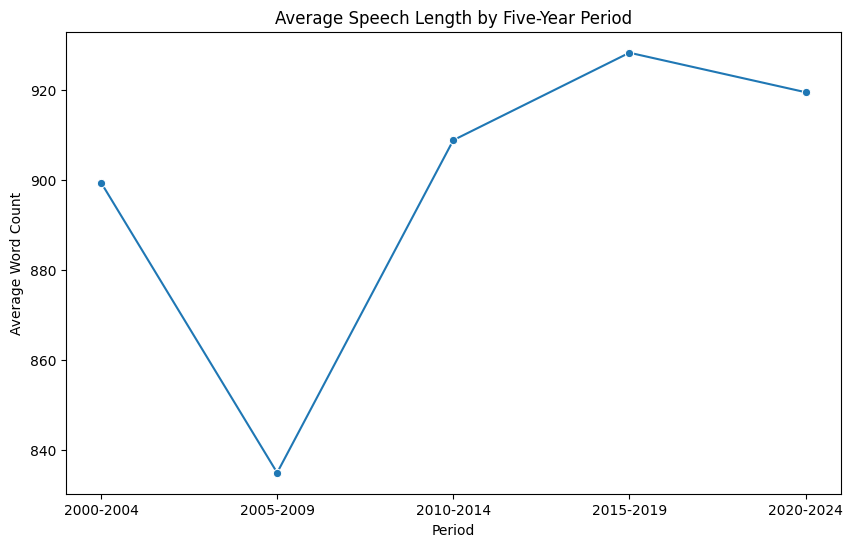

In [17]:
def stats_by_period():
    stats = df.groupby('Period').agg({
        'Word_Count': ['mean', 'median', 'std']
    }).reset_index()
    print("\nStats by Five-Year Period:")
    print(stats)
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Period', y=('Word_Count', 'mean'), data=stats, marker='o')
    plt.title("Average Speech Length by Five-Year Period")
    plt.ylabel("Average Word Count")
    #plt.xticks(rotation=45)
    plt.savefig("speech_length_period.png")
    plt.show()

stats_by_period()


Word Trends by Five-Year Period:
           climate  peace  poverty  security  development
2000-2004      380   6596     2187      7209         7098
2005-2009     2402   5290     1695      6193         8046
2010-2014     2463   5893     1535      6484         9252
2015-2019     3822   6524     1623      6321         8890
2020-2024     4705   5679      963      5678         6257


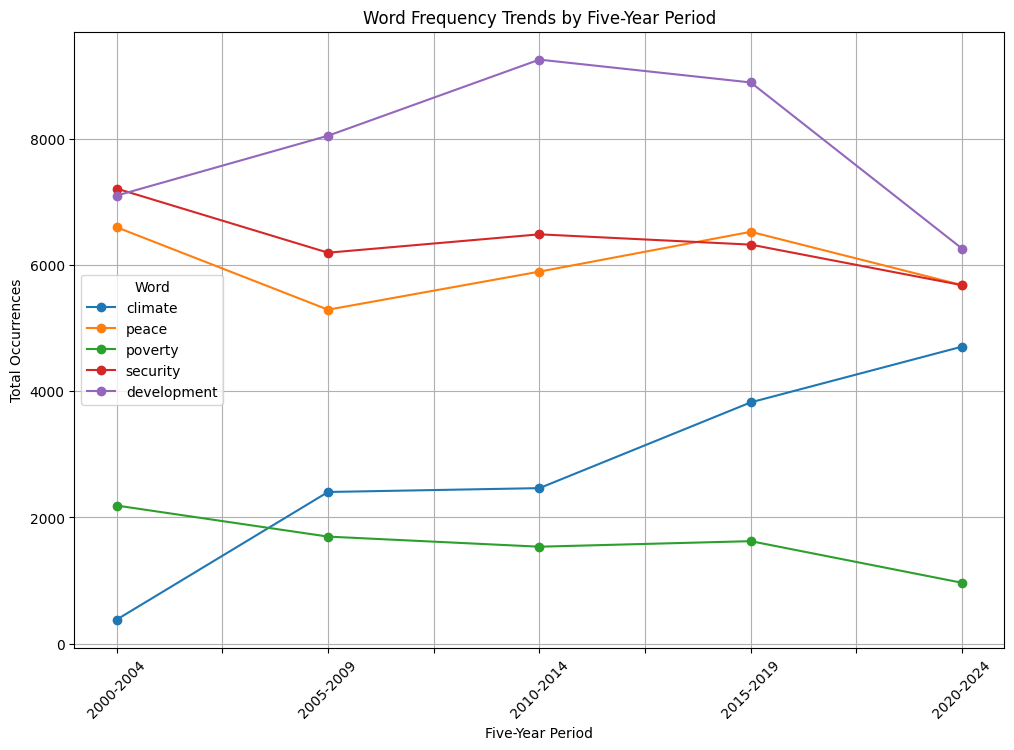

In [18]:
def word_trends(words_to_track=['climate', 'peace', 'poverty', 'security', 'development']):
    trends = pd.DataFrame(index=['2000-2004', '2005-2009', '2010-2014', '2015-2019', '2020-2024'], columns=words_to_track)
    
    for word in words_to_track:
        df[word] = df['Tokens'].apply(lambda tokens: tokens.count(word))
        trend_data = df.groupby('Period')[word].sum()
        trends[word] = trend_data
    
    print("\nWord Trends by Five-Year Period:")
    print(trends)
    
    # Line chart for word trends
    trends.plot(kind='line', marker='o', figsize=(12, 8))
    plt.title("Word Frequency Trends by Five-Year Period")
    plt.xlabel("Five-Year Period")
    plt.ylabel("Total Occurrences")
    plt.legend(title="Word")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig("word_trends_period.png")
    plt.show()
    
word_trends()

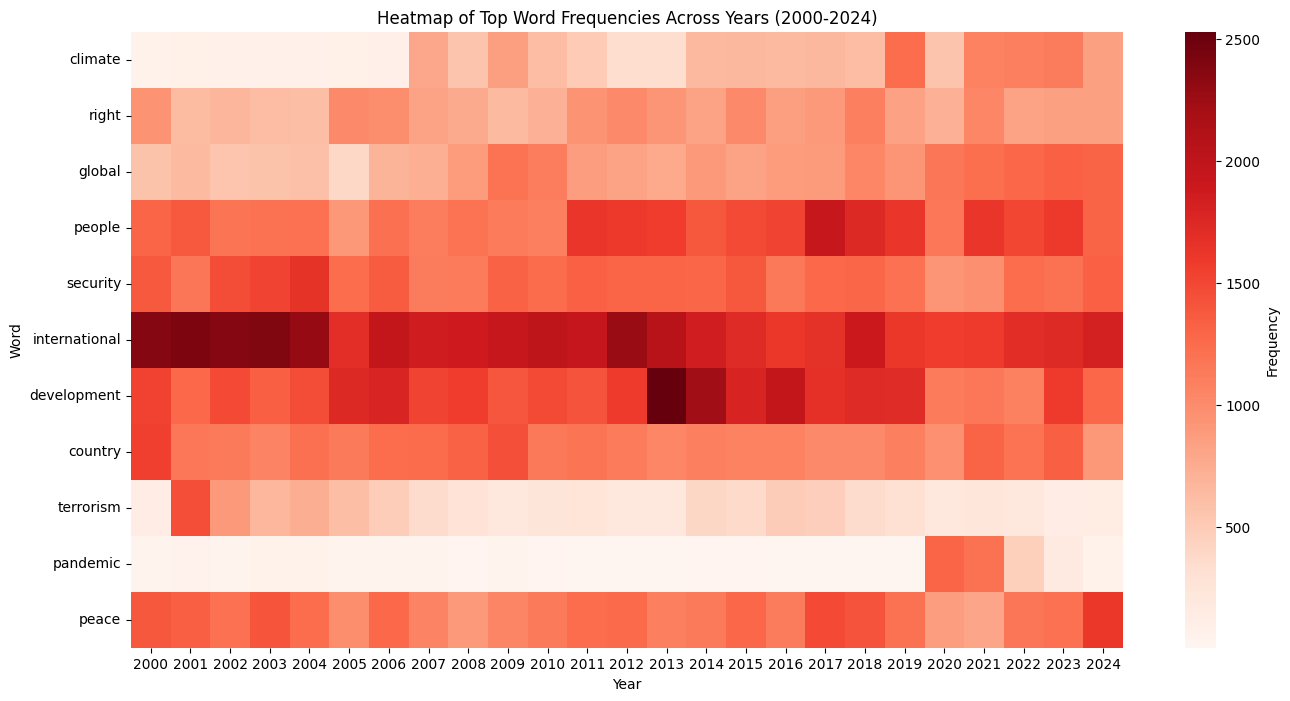

In [19]:
def heatmap_top_words(n=5):
    years = sorted(df['Year'].unique())
    top_words_years = {}
    for year in years:
        year_df = df[df['Year'] == year]
        all_words = []
        for words in year_df['Tokens']:
            all_words.extend(words)
        word_counts = Counter(all_words)
        top_words_years[year] = [w[0] for w in word_counts.most_common(n)]
    
    unique_words = list(set([word for words in top_words_years.values() for word in words]))
    freq_matrix = pd.DataFrame(0, index=unique_words, columns=years)
    
    for year in years:
        year_df = df[df['Year'] == year]
        all_words = []
        for words in year_df['Tokens']:
            all_words.extend(words)
        word_counts = Counter(all_words)
        for word in unique_words:
            freq_matrix.at[word, year] = word_counts[word]
    
    plt.figure(figsize=(16, 8))  # Increased width (16) and reduced height (8) for a wider chart
    sns.heatmap(freq_matrix, cmap='Reds', cbar_kws={'label': 'Frequency'}, annot=False)
    plt.title(f"Heatmap of Top Word Frequencies Across Years (2000-2024)")
    plt.xlabel("Year")
    plt.ylabel("Word")
    plt.savefig("heatmap_words_year.png")
    plt.show()
    
heatmap_top_words(n=5)

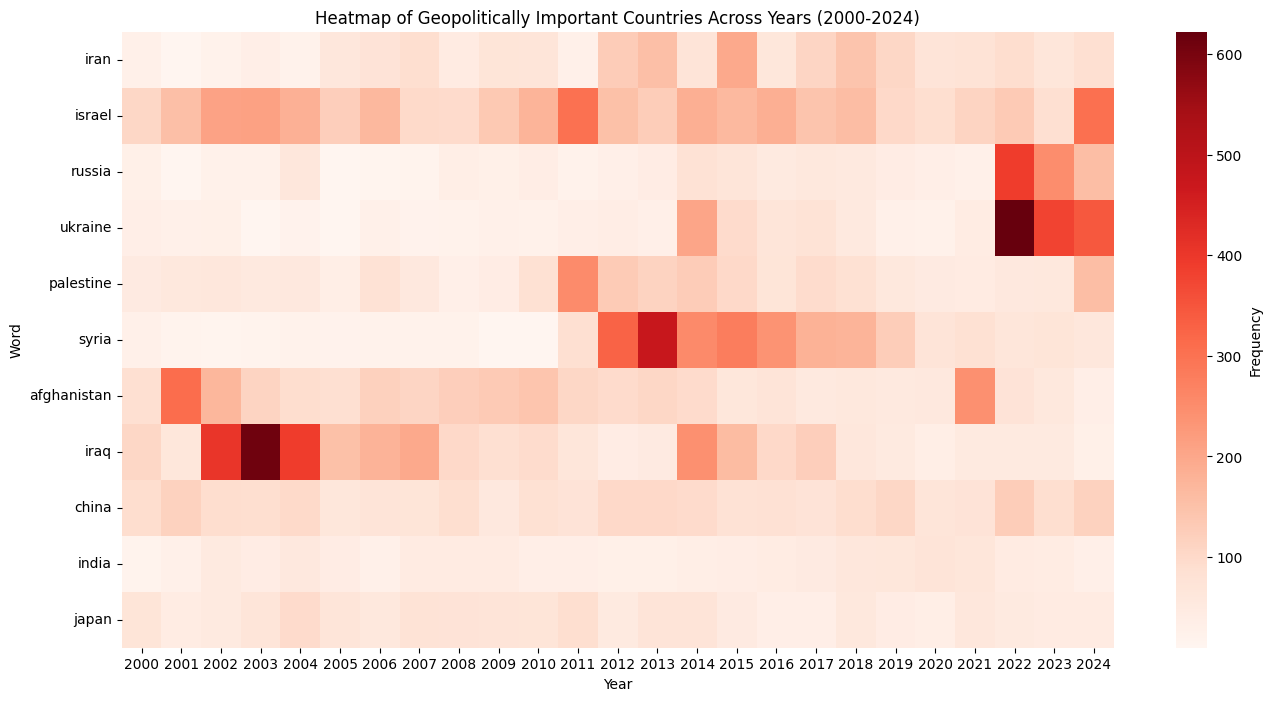

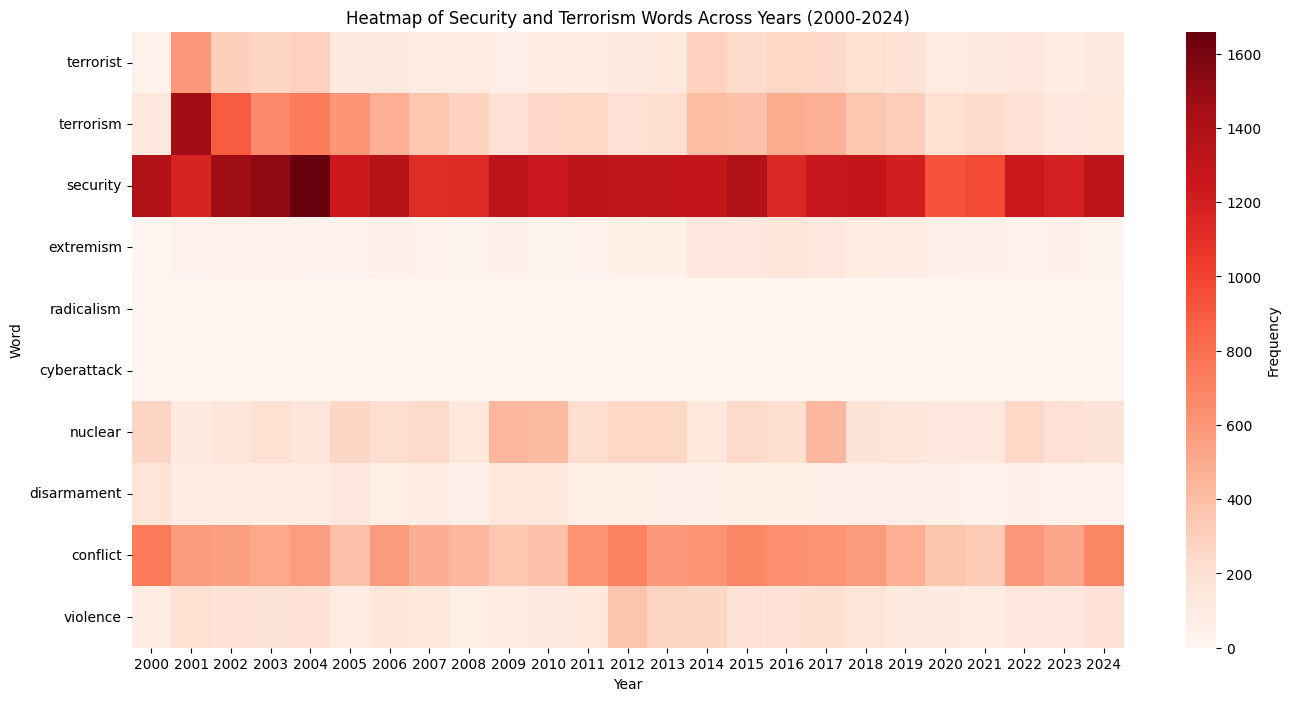

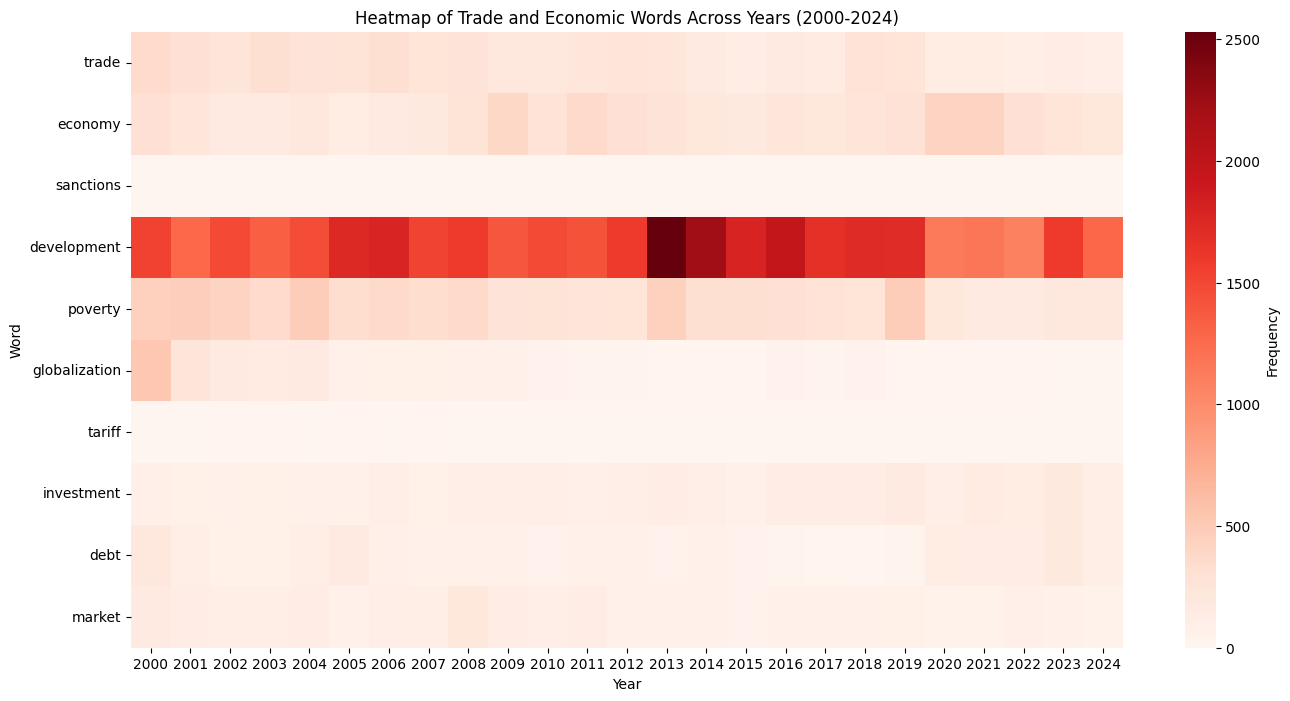

In [20]:
# Define the word lists for each heatmap
geopolitical_words = ['iran', 'israel', 'russia', 'ukraine', 'palestine', 'syria', 'afghanistan', 'iraq', 'china', 'india', 'japan']
security_words = ['terrorist', 'terrorism', 'security', 'extremism', 'radicalism', 'cyberattack', 'nuclear', 'disarmament', 'conflict', 'violence']
economic_words = ['trade', 'economy', 'sanctions', 'development', 'poverty', 'globalization', 'tariff', 'investment', 'debt', 'market']

# Function to generate heatmap for a given list of words
def heatmap_specific_words(word_list, title, filename):
    years = sorted(df['Year'].unique())
    
    # Create frequency matrix for the specified words
    freq_matrix = pd.DataFrame(0, index=word_list, columns=years)
    
    # Calculate word frequencies for each year
    for year in years:
        year_df = df[df['Year'] == year]
        all_words = []
        for words in year_df['Tokens']:
            all_words.extend(words)
        word_counts = Counter(all_words)
        for word in word_list:
            freq_matrix.at[word, year] = word_counts.get(word, 0)
    
    # Plot heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(freq_matrix, cmap='Reds', cbar_kws={'label': 'Frequency'}, annot=False)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Word")
    plt.savefig(filename)
    plt.show()

# Generate heatmaps for each topic
heatmap_specific_words(geopolitical_words, "Heatmap of Geopolitically Important Countries Across Years (2000-2024)", "heatmap_geopolitical.png")
heatmap_specific_words(security_words, "Heatmap of Security and Terrorism Words Across Years (2000-2024)", "heatmap_security.png")
heatmap_specific_words(economic_words, "Heatmap of Trade and Economic Words Across Years (2000-2024)", "heatmap_economic.png")

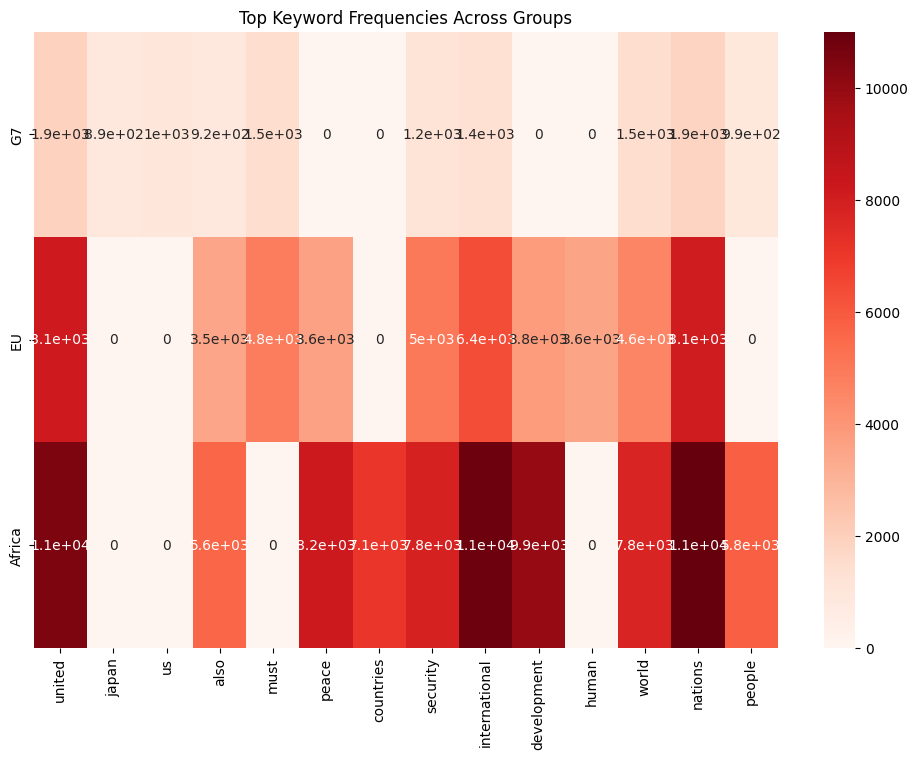

In [21]:
# Filter dataframes
df_g7 = df[df['Country'].isin(g7_countries)]
df_eu = df[df['Country'].isin(eu_countries)]
df_africa = df[df['Country'].isin(african_countries)]

# Function to get top words
def get_top_words(texts, n=10):
    stop_words = set(stopwords.words('english'))
    all_words = ' '.join(texts.dropna()).lower()
    tokens = word_tokenize(all_words)
    filtered = [w for w in tokens if w.isalpha() and w not in stop_words]
    return Counter(filtered).most_common(n)

# Get tops
top_g7 = get_top_words(df_g7['Speech'])
top_eu = get_top_words(df_eu['Speech'])
top_africa = get_top_words(df_africa['Speech'])

# Plot bar chart
groups = ['G7', 'EU', 'Africa']
tops = [dict(top_g7), dict(top_eu), dict(top_africa)]
words = set(w for group in tops for w in group.keys())
df_comp = pd.DataFrame({group: {w: tops[i].get(w, 0) for w in words} for i, group in enumerate(groups)}).T

plt.figure(figsize=(12, 8))
sns.heatmap(df_comp, annot=True, cmap='Reds')
plt.title('Top Keyword Frequencies Across Groups')
plt.show()

In [43]:
df_copy = df
df_copy['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x) if x else '')

def lda_topic_modeling(num_topics=8):
    # Create a dictionary and corpus for LDA using the copy
    dictionary = corpora.Dictionary(df_copy['Tokens'])
    corpus = [dictionary.doc2bow(text) for text in df_copy['Tokens']]
    
    # Train LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15)
    
    # Print topics
    print("\nLDA Topics:")
    topics = lda_model.print_topics()
    for topic in topics:
        print(topic)
    
    # Visualize with pyLDAvis
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis, 'lda_visualization00.html')
    print("LDA visualization saved as 'lda_visualization.html'. Open in a web browser to explore.")

lda_topic_modeling(num_topics=10)


LDA Topics:
(0, '0.023*"international" + 0.011*"security" + 0.010*"council" + 0.009*"right" + 0.009*"organization" + 0.008*"state" + 0.007*"human" + 0.007*"development" + 0.006*"conflict" + 0.006*"peace"')
(1, '0.015*"people" + 0.008*"country" + 0.006*"year" + 0.006*"human" + 0.006*"right" + 0.005*"government" + 0.005*"today" + 0.005*"time" + 0.005*"democracy" + 0.005*"great"')
(2, '0.023*"international" + 0.014*"development" + 0.013*"peace" + 0.012*"security" + 0.011*"country" + 0.010*"effort" + 0.009*"people" + 0.008*"cooperation" + 0.007*"community" + 0.007*"economic"')
(3, '0.012*"security" + 0.010*"international" + 0.008*"need" + 0.008*"human" + 0.008*"year" + 0.007*"global" + 0.007*"council" + 0.007*"right" + 0.006*"european" + 0.006*"conflict"')
(4, '0.021*"international" + 0.012*"development" + 0.008*"cooperation" + 0.008*"security" + 0.007*"global" + 0.007*"state" + 0.007*"effort" + 0.007*"economic" + 0.007*"country" + 0.006*"kingdom"')
(5, '0.019*"development" + 0.015*"devel

In [23]:
def nmf_topic_modeling(num_topics=8):
    # TF-IDF Vectorizer using the copy
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(df_copy['Processed_Text'])
    
    # Train NMF model
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_topics = nmf_model.fit_transform(tfidf)
    
    # Get feature names
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Print topics
    print("\nNMF Topics:")
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx}:")
        top_words_idx = topic.argsort()[:-6:-1]  # Top 5 words
        top_words = [tfidf_feature_names[i] for i in top_words_idx]
        print(f"Top words: {top_words}")

nmf_topic_modeling(num_topics=10)


NMF Topics:
Topic 0:
Top words: ['international', 'security', 'council', 'terrorism', 'organization']
Topic 1:
Top words: ['pandemic', 'climate', 'global', 'vaccine', 'crisis']
Topic 2:
Top words: ['people', 'right', 'human', 'year', 'today']
Topic 3:
Top words: ['african', 'africa', 'peace', 'continent', 'republic']
Topic 4:
Top words: ['country', 'development', 'develop', 'international', 'economic']
Topic 5:
Top words: ['arab', 'international', 'palestinian', 'israel', 'peace']
Topic 6:
Top words: ['island', 'pacific', 'small', 'islands', 'ocean']
Topic 7:
Top words: ['development', 'sustainable', 'agenda', 'goal', 'peace']
Topic 8:
Top words: ['ukraine', 'russia', 'war', 'europe', 'aggression']
Topic 9:
Top words: ['korea', 'republic', 'korean', 'nuclear', 'democratic']


C:\Users\cappr\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [24]:
import re

df_copy['paragraphs'] = df_copy['Speech'].map(lambda text: re.split('\.\s*\n', str(text) if pd.notna(text) else ''))
df_copy['number_of_paragraphs'] = df_copy['paragraphs'].map(len)

# Flatten paragraphs into a new DataFrame
paragraph_df = pd.DataFrame([
    {"text": paragraph, "year": year} 
    for paragraphs, year in zip(df_copy['paragraphs'], df_copy['Year']) 
    for paragraph in paragraphs if paragraph
])
paragraph_df['year'] = paragraph_df['year'].astype(int)

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\cappr\AppData\Local\Temp\ipykernel_3312\1324567976.py:3: SyntaxWarning: invalid escape sequence '\.'
  df_copy['paragraphs'] = df_copy['Speech'].map(lambda text: re.split('\.\s*\n', str(text) if pd.notna(text) else ''))


In [25]:
paragraph_df['Tokens'] = paragraph_df['text'].apply(preprocess_text)
paragraph_df['Processed_Text'] = paragraph_df['Tokens'].apply(lambda x: ' '.join(x) if x else '')

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# TF-IDF Vectorizer for paragraphs
tfidf_para_vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'), min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df['Processed_Text'])
print(f"TF-IDF Paragraph Vectors Shape: {tfidf_para_vectors.shape}")

# Count Vectorizer for LDA
count_para_vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df['text'])
print(f"Count Paragraph Vectors Shape: {count_para_vectors.shape}")

# NMF Topic Modeling
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

# LDA Topic Modeling
lda_para_model = LatentDirichletAllocation(n_components=10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

# Display Topics Function (similar to professor's format)
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # Invert sort order
        print(f"\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]] * 100.0 / total)))

# Display NMF Topics
print("\nNMF Topics:")
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

# Display LDA Topics
print("\nLDA Topics:")
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

# Topic Sizes
print("\nNMF Topic Sizes (%):")
print(W_para_matrix.sum(axis=0) / W_para_matrix.sum() * 100.0)
print("\nLDA Topic Sizes (%):")
print(W_lda_para_matrix.sum(axis=0) / W_lda_para_matrix.sum() * 100.0)



TF-IDF Paragraph Vectors Shape: (137278, 13780)
Count Paragraph Vectors Shape: (137278, 19115)

NMF Topics:

Topic 00
  country (3.18)
  develop (2.53)
  economic (1.05)
  small (0.72)
  trade (0.69)

Topic 01
  development (5.52)
  sustainable (2.82)
  goal (2.43)
  agenda (1.64)
  millennium (1.29)

Topic 02
  session (4.01)
  election (2.39)
  congratulate (2.25)
  like (1.84)
  wish (1.69)

Topic 03
  right (5.97)
  human (5.38)
  respect (1.17)
  freedom (1.08)
  democracy (0.86)

Topic 04
  council (6.10)
  security (5.57)
  reform (3.21)
  member (1.70)
  permanent (1.20)

Topic 05
  climate (4.78)
  change (4.46)
  global (1.31)
  challenge (1.10)
  agreement (0.70)

Topic 06
  peace (1.85)
  people (1.28)
  conflict (1.02)
  region (0.64)
  palestinian (0.58)

Topic 07
  international (3.86)
  community (1.79)
  terrorism (1.54)
  law (0.97)
  cooperation (0.85)

Topic 08
  thank (33.94)
  attention (3.90)
  like (1.54)
  support (1.09)
  effort (0.95)

Topic 09
  nuclear (5.5


Generating NMF Word Clouds...
Generating LDA Word Clouds...


  0%|          | 0/25 [00:00<?, ?it/s]

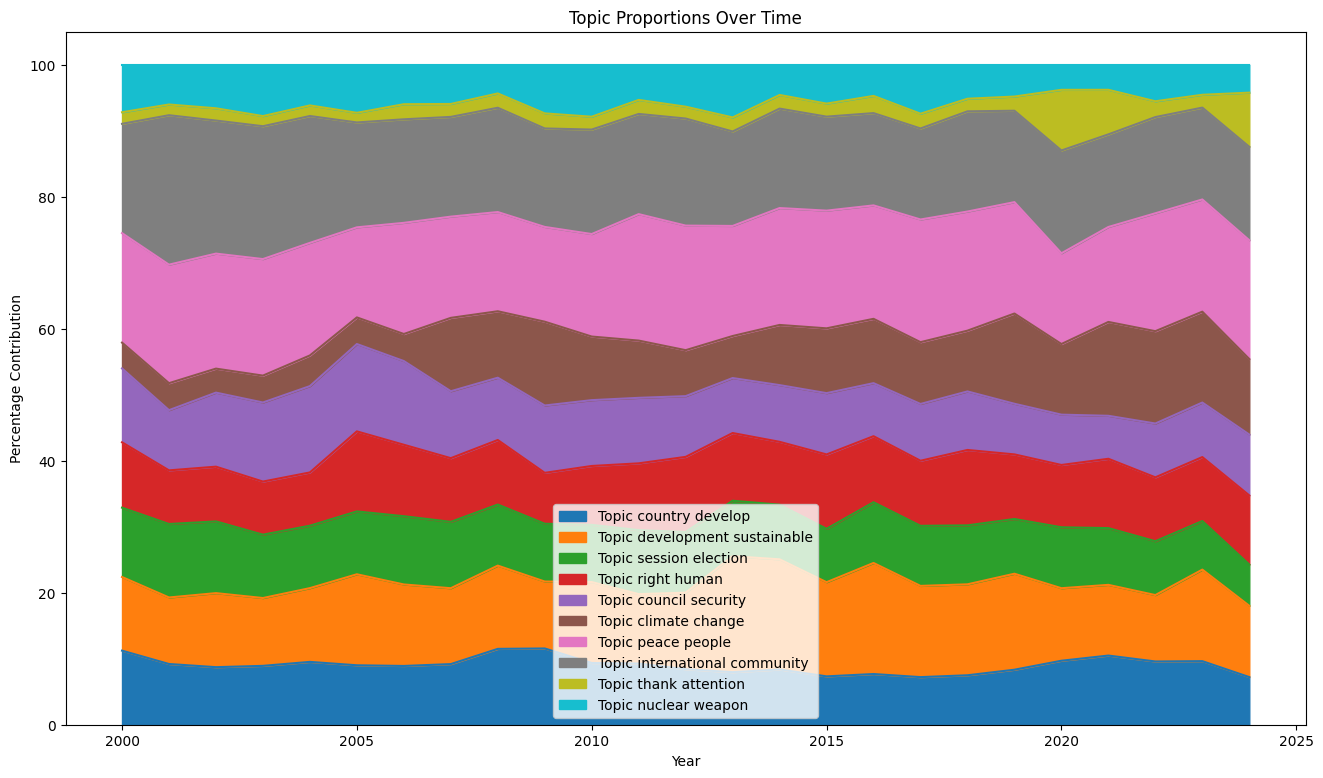

In [27]:
# pyLDAvis Visualization (with vocab and term_frequency)
vocab = count_para_vectorizer.get_feature_names_out()
# Calculate term frequencies across the corpus
term_frequency = np.array(count_para_vectors.sum(axis=0))[0]
# Topic-term distributions (normalize components_)
topic_term_dists = lda_para_model.components_ / lda_para_model.components_.sum(axis=1)[:, np.newaxis]
# Document-topic distributions
doc_topic_dists = W_lda_para_matrix
# Document lengths (sum of counts per document)
doc_lengths = count_para_vectors.sum(axis=1).A1
lda_display = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'lda_visualization1.html')

# Word Clouds for Topics
def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1]  # Invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12, 12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(f'topic{topic}.png')
        plt.close()

print("\nGenerating NMF Word Clouds...")
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())
print("Generating LDA Word Clouds...")
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

# Topic Change Over Time
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

year_data = []
for year in tqdm(np.unique(paragraph_df["year"])):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0) / W_year.sum() * 100.0))

df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16, 9))
plt.title("Topic Proportions Over Time")
plt.xlabel("Year")
plt.ylabel("Percentage Contribution")
plt.savefig("topic_proportions_over_time.png")
plt.show()

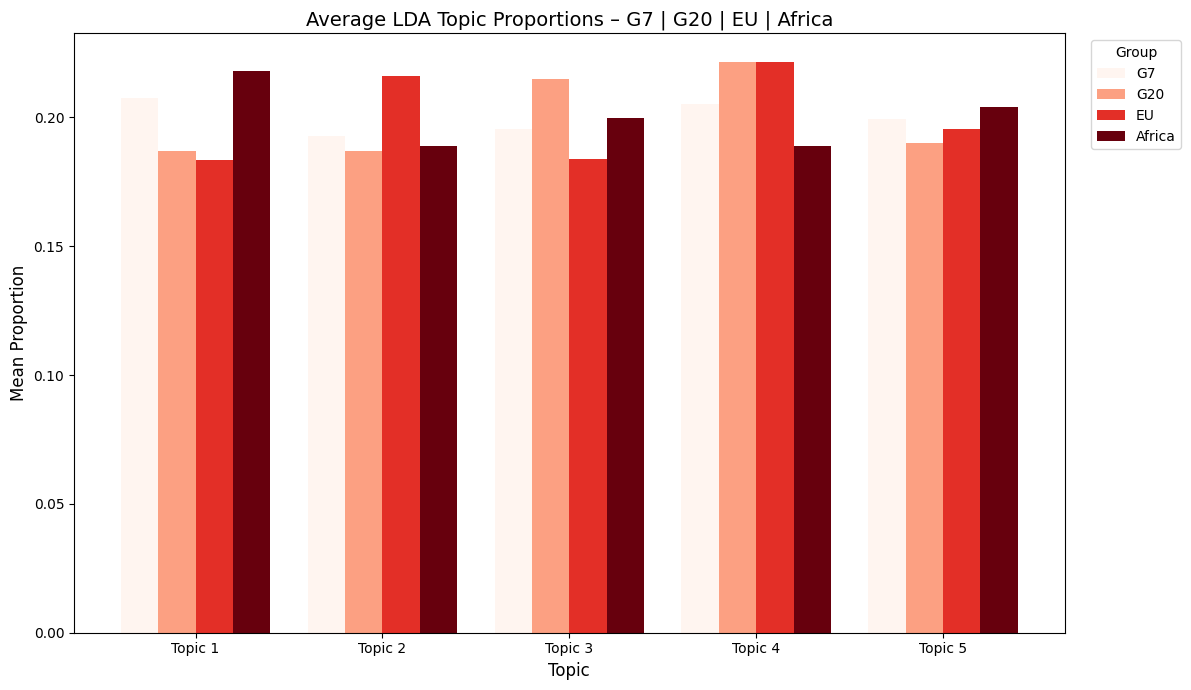

In [52]:
g7_countries = ['Canada', 'France', 'Germany', 'Italy', 'Japan',
                'United Kingdom', 'United States']

g20_countries = ['Argentina', 'Australia', 'Brazil', 'Canada', 'China',
                 'France', 'Germany', 'India', 'Indonesia', 'Italy',
                 'Japan', 'Mexico', 'Russia', 'Saudi Arabia',
                 'South Africa', 'South Korea', 'Turkey',
                 'United Kingdom', 'United States']

eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
                'Czech Republic', 'Denmark', 'Estonia', 'Finland',
                'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
                'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
                'Netherlands', 'Poland', 'Portugal', 'Romania',
                'Slovakia', 'Slovenia', 'Spain', 'Sweden']

african_countries = [  # list of 54 African states – you can paste the full list
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad',
    'Comoros', 'Congo', 'Democratic Republic of the Congo', 'Djibouti',
    'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia',
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast',
    'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi',
    'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique',
    'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
    'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
    'Zambia', 'Zimbabwe']

df_g7      = df[df['Country'].isin(g7_countries)]
df_g20     = df[df['Country'].isin(g20_countries)]
df_eu      = df[df['Country'].isin(eu_countries)]
df_africa  = df[df['Country'].isin(african_countries)]

def preprocess(series):
    stop_words = set(stopwords.words('english'))
    return [
        [w for w in word_tokenize(str(doc).lower())
         if w.isalpha() and w not in stop_words]
        for doc in series.dropna()
    ]

def run_lda(group_df, num_topics=5, passes=15, random_state=42):
    texts = preprocess(group_df['Tokens'])
    if not texts:
        raise ValueError(f"Empty corpus for {group_df['Country'].unique()}")
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(t) for t in texts]
    lda = LdaModel(corpus,
                   num_topics=num_topics,
                   id2word=dictionary,
                   passes=passes,
                   random_state=random_state,
                   alpha='auto',
                   eta='auto')
    return lda, corpus

# Run models
lda_g7,     corp_g7     = run_lda(df_g7)
lda_g20,    corp_g20    = run_lda(df_g20)
lda_eu,     corp_eu     = run_lda(df_eu)
lda_africa, corp_africa = run_lda(df_africa)


def avg_topic_props(lda, corpus):
    props = []
    for bow in corpus:
        doc_topics = lda.get_document_topics(bow, minimum_probability=0.0)
        row = [0.0] * lda.num_topics
        for tid, prob in doc_topics:
            row[tid] = prob
        props.append(row)
    return np.mean(props, axis=0)

props_g7     = avg_topic_props(lda_g7,     corp_g7)
props_g20    = avg_topic_props(lda_g20,    corp_g20)
props_eu     = avg_topic_props(lda_eu,     corp_eu)
props_africa = avg_topic_props(lda_africa, corp_africa)

# SIDE-BY-SIDE BAR CHART
df_props = pd.DataFrame({
    'G7':      props_g7,
    'G20':     props_g20,
    'EU':      props_eu,
    'Africa':  props_africa
}, index=[f'Topic {i+1}' for i in range(5)])

ax = df_props.plot(
    kind='bar',
    figsize=(12, 7),
    width=0.8,
    cmap='Reds'         
)
ax.set_title('Average LDA Topic Proportions – G7 | G20 | EU | Africa', fontsize=14)
ax.set_ylabel('Mean Proportion', fontsize=12)
ax.set_xlabel('Topic', fontsize=12)
ax.legend(title='Group', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('lda_topic_proportions_g7_g20_eu_africa1.png', dpi=300, bbox_inches='tight')
plt.show()

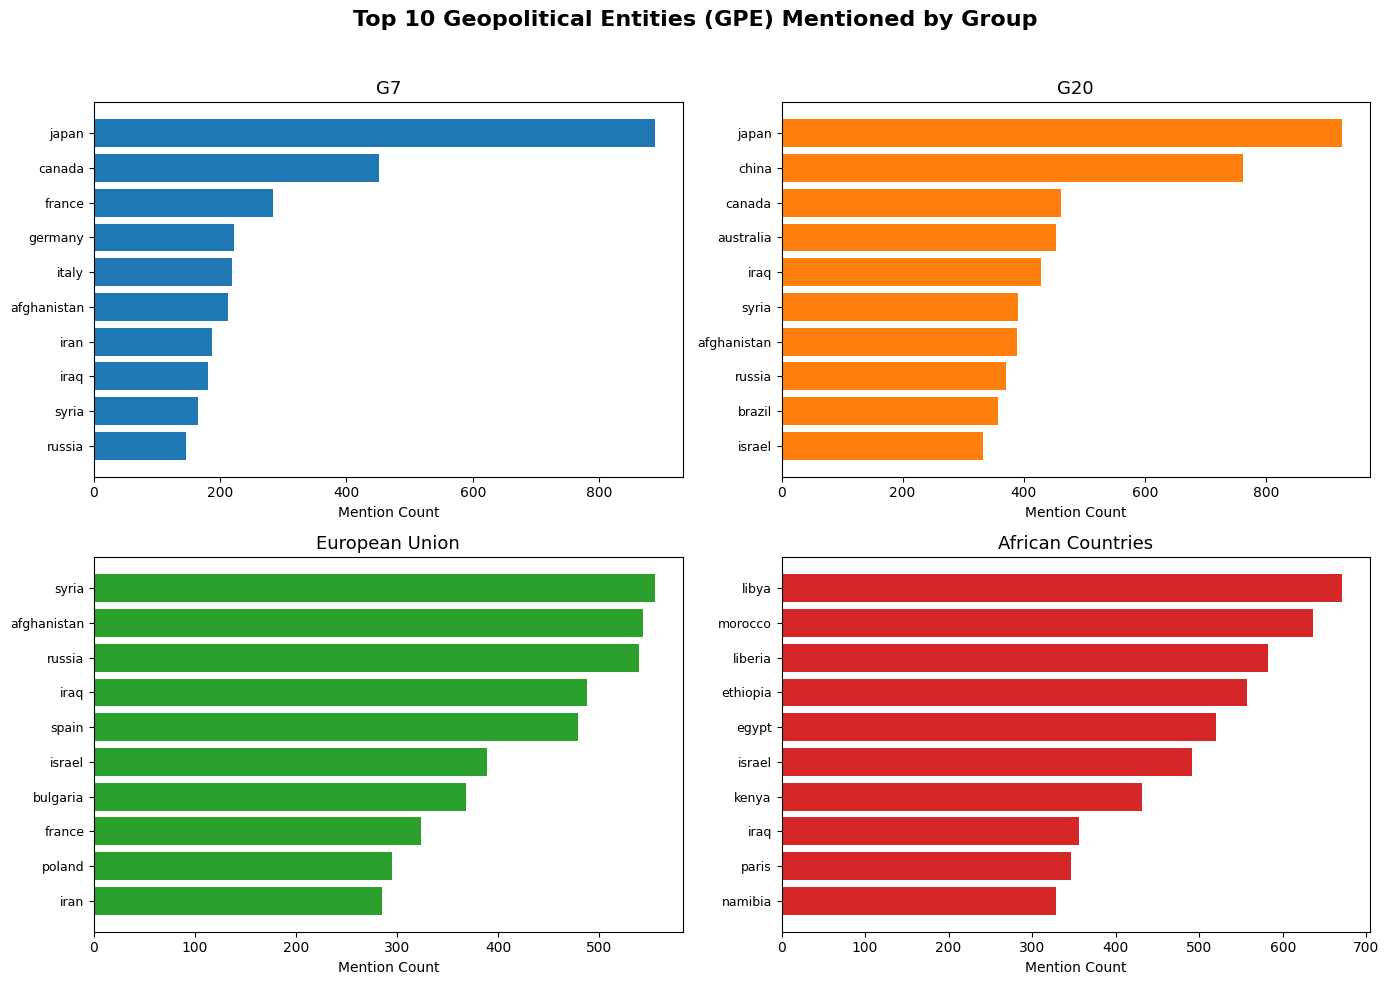

In [53]:
import warnings

# NER fun
def extract_entities(series, ent_type='GPE', batch_size=100):
    """
    series   – pandas Series with the raw speech texts
    ent_type – 'GPE' for countries/cities, 'ORG' for organisations, …
    """
    entities = Counter()
    # batch processing + disable unnecessary components
    for doc in nlp.pipe(
        series.dropna().astype(str),
        disable=['parser', 'tagger', 'lemmatizer'],
        batch_size=batch_size
    ):
        entities.update(ent.text for ent in doc.ents if ent.label_ == ent_type)
    return entities.most_common(10)


# EXTRACT TOP GPE FOR EACH GROUP
top_gpe_g7     = extract_entities(df_g7['Tokens'],     'GPE')
top_gpe_g20    = extract_entities(df_g20['Tokens'],    'GPE')
top_gpe_eu     = extract_entities(df_eu['Tokens'],     'GPE')
top_gpe_africa = extract_entities(df_africa['Tokens'], 'GPE')

# PREPARING DATA FOR PLOTTING
def unpack(counter_list):
    if not counter_list:                     
        return [], []
    labels, counts = zip(*counter_list)
    return labels, counts

labels_g7,     counts_g7     = unpack(top_gpe_g7)
labels_g20,    counts_g20    = unpack(top_gpe_g20)
labels_eu,     counts_eu     = unpack(top_gpe_eu)
labels_africa, counts_africa = unpack(top_gpe_africa)

# bar chart
warnings.filterwarnings('ignore', category=UserWarning, module='spacy') 

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
fig.suptitle('Top 10 Geopolitical Entities (GPE) Mentioned by Group',
             fontsize=16, weight='bold')

# G7
axes[0,0].barh(labels_g7, counts_g7, color='#1f77b4')
axes[0,0].set_title('G7', fontsize=13)
axes[0,0].invert_yaxis()

# G20
axes[0,1].barh(labels_g20, counts_g20, color='#ff7f0e')
axes[0,1].set_title('G20', fontsize=13)
axes[0,1].invert_yaxis()

# EU
axes[1,0].barh(labels_eu, counts_eu, color='#2ca02c')
axes[1,0].set_title('European Union', fontsize=13)
axes[1,0].invert_yaxis()

# Africa
axes[1,1].barh(labels_africa, counts_africa, color='#d62728')
axes[1,1].set_title('African Countries', fontsize=13)
axes[1,1].invert_yaxis()

# common layout tweaks
for ax in axes.flat:
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xlabel('Mention Count')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('top_gpe_mentions_by_group1.png', dpi=300, bbox_inches='tight')
plt.show()

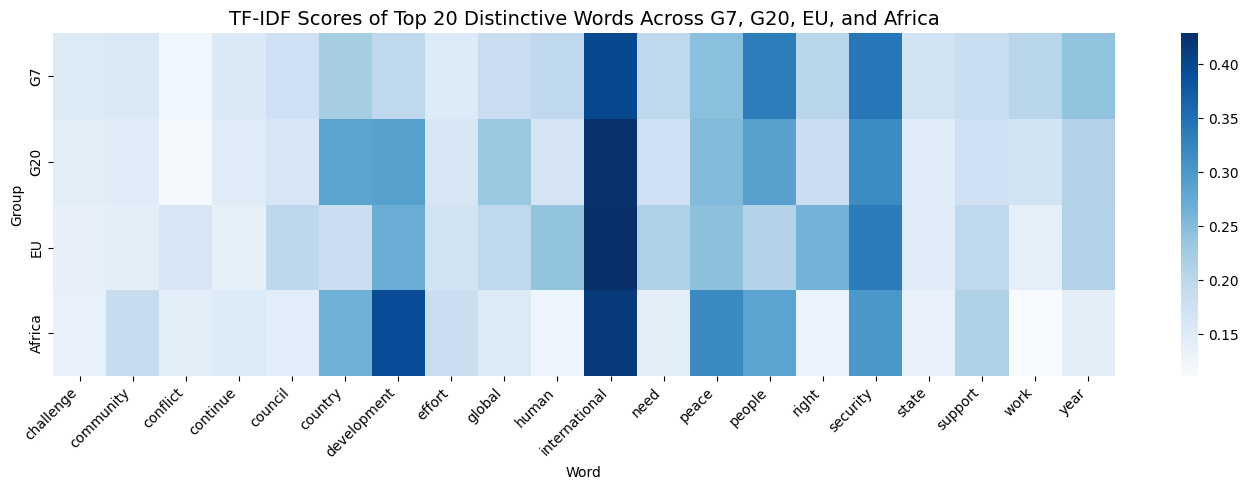

In [54]:
# TF-IDF ACROSS ALL FOUR GROUPS
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all speeches per group into one string
groups = {
    'G7':      ' '.join(df_g7['Tokens'].dropna().astype(str)),
    'G20':     ' '.join(df_g20['Tokens'].dropna().astype(str)),
    'EU':      ' '.join(df_eu['Tokens'].dropna().astype(str)),
    'Africa':  ' '.join(df_africa['Tokens'].dropna().astype(str))
}

# Fit TF-IDF on the four "documents"
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20,
    lowercase=True,
    token_pattern=r'(?u)\b\w\w+\b'
)
tfidf_matrix = vectorizer.fit_transform(groups.values())
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=groups.keys(),
    columns=vectorizer.get_feature_names_out()
)

# HEATMAP
plt.figure(figsize=(14, 5))
sns.heatmap(df_tfidf, cmap='Blues')
plt.title('TF-IDF Scores of Top 20 Distinctive Words Across G7, G20, EU, and Africa', fontsize=14)
plt.xlabel('Word')
plt.ylabel('Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('tfidf_heatmap_top_words_groups1.png', dpi=300, bbox_inches='tight')
plt.show()

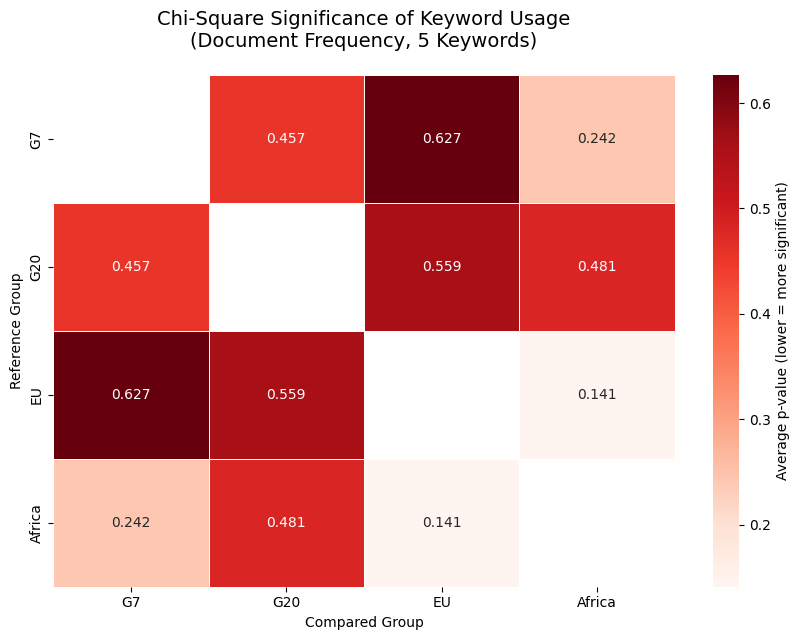

In [31]:
# CHI-SQUARE USING DOCUMENT FREQUENCY
from scipy.stats import chi2_contingency

def chi_square_doc_freq(word, texts1, texts2):
    """
    Count how many documents in each group CONTAIN the word at least once.
    """
    # Convert to lowercase once
    texts1 = [str(t).lower() for t in texts1]
    texts2 = [str(t).lower() for t in texts2]
    
    # Document frequency (number of speeches containing the word)
    c1 = sum(1 for text in texts1 if word.lower() in text)
    c2 = sum(1 for text in texts2 if word.lower() in text)
    
    n1, n2 = len(texts1), len(texts2)
    
    # Contingency table: [contains, does not contain]
    table = [
        [c1, n1 - c1],
        [c2, n2 - c2]
    ]
    
    # Safety: avoid zero rows/columns
    if min(table[0][0], table[0][1], table[1][0], table[1][1]) < 0:
        return np.nan
    if table[0][0] == 0 and table[1][0] == 0:
        return np.nan  # word never appears
    
    try:
        chi2, p, dof, expected = chi2_contingency(table)
        # Warn if expected freq < 5 in >20% cells
        if np.any(expected < 5):
            return p  # still return p, but consider Yates' correction in paper
        return p
    except:
        return np.nan

group_data = {
    'G7':     df_g7['Speech'].dropna(),
    'G20':    df_g20['Speech'].dropna(),
    'EU':     df_eu['Speech'].dropna(),
    'Africa': df_africa['Speech'].dropna()
}

keywords = ['climate', 'security', 'development', 'peace', 'poverty']
groups = list(group_data.keys())

# P-VALUE MATRIX
p_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)

for g1 in groups:
    for g2 in groups:
        if g1 == g2:
            p_matrix.loc[g1, g2] = np.nan
            continue
        p_vals = []
        for word in keywords:
            p = chi_square_doc_freq(word, group_data[g1], group_data[g2])
            if not np.isnan(p):
                p_vals.append(p)
        p_matrix.loc[g1, g2] = np.mean(p_vals) if p_vals else np.nan


# HEATMAP WITH BETTER ANNOTATIONS
plt.figure(figsize=(8.5, 6.5))
ax = sns.heatmap(
    p_matrix.astype(float),
    annot=True,
    cmap='Reds',
    fmt='.3f',
    linewidths=.7,
    cbar_kws={'label': 'Average p-value (lower = more significant)'},
    mask=p_matrix.isnull()
)

# Highlight significant cells (p < 0.05)
for i in range(len(groups)):
    for j in range(len(groups)):
        if i != j:
            val = p_matrix.iloc[i, j]
            if not np.isnan(val) and val < 0.05:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title('Chi-Square Significance of Keyword Usage\n(Document Frequency, 5 Keywords)', 
          fontsize=14, pad=20)
plt.xlabel('Compared Group')
plt.ylabel('Reference Group')
plt.tight_layout()
plt.show()